# Определение перспективного тарифа для телеком-компании

В исследовании будет рассмотрена деятельность федерального оператора сотовой связи "Мегалайн", где будут проанализированы два тарифных плана: "Смарт" и "Ультра". <br>
Задача исследования - проанализировать поведений клиентов и определить какой тариф выгоднее , и приносит больше денег, тем самым коммерческий департамент хочет скорректировать рекламный бюджет. <br>
В работе будет использоваться выборка из 500 пользователей оператора с полной расшифровкой их активность (кто, локация, даты, тариф, количество звонков и сообщений).

## Изучение общей информации

Для начала работы с данными и последующего их анализа, загрузим необходимые библиотеки

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
from scipy import stats as st
import os #для использования в функции открытия файлов `open_file`
#отключим уведомления об ограничениях
pd.options.mode.chained_assignment = None

In [5]:
#для удобства создадим функцию для добавления файлов
def open_file (file_name,df_out_name):
    #проверяем локацию, если есть доступ с локального ПК, то берем адрес оттуда, иначе сетевой
    path = f'C:/datasets/{file_name}.csv' if os.path.isfile(f'C:/datasets/users.csv') else f'/datasets/{file_name}.csv'
    #назначаем переменную таблицы с пользовательским наименованием
    globals()[f"df_{df_out_name}"] = pd.read_csv(path, sep=',', decimal='.')

С помощью функции `open_file` и заранее подготовленного списка названий файлов, загрузим их в тетрадь

In [6]:
#наименования таблиц и их выходные названия
files_names=['users','messages','calls','internet','tariffs']
df_names=['users','sms','calls','inet','tariffs']

#загрузка таблиц
for i in enumerate(files_names): open_file(files_names[i[0]],df_names[i[0]])

### Проверка таблицы пользователей

In [7]:
#посмотрим общую информацию о данных в таблице df_users и её статистическую сводку
df_users.info();df_users.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
count,500.000000,500.00000,38,500,500,500,500,500
unique,NaN,NaN,33,76,246,419,270,2
top,NaN,NaN,2018-12-09,Москва,Радим,Андреенко,2018-05-28,smart
freq,NaN,NaN,2,99,6,5,8,351
mean,1249.500000,46.58800,NaN,NaN,NaN,NaN,NaN,NaN
std,144.481833,16.66763,NaN,NaN,NaN,NaN,NaN,NaN
min,1000.000000,18.00000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1124.750000,32.00000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1249.500000,46.00000,NaN,NaN,NaN,NaN,NaN,NaN
75%,1374.250000,62.00000,NaN,NaN,NaN,NaN,NaN,NaN


В части целостности данных вопросов по данной таблице нет, пропусков нет, кроме даты ухода пользователя `churn_date`, что позволительно. В части типов данных понадобится обработки, по столбцам `city`, `first_name` и `tariff` можно применить формат `category`, а по `user_id` и `age` изменить битность типа до наименьшего.

### Проверка биллинговых данных
В данной группе рассмотрим таблицы СМС, звонки и интернет
#### СМС

In [8]:
#посмотрим общую информацию и её статистическую сводку
df_sms.info();df_sms.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
count,123036,123036,123036.000000
unique,123036,364,NaN
top,1411_214,2018-12-31,NaN
freq,1,859,NaN
mean,NaN,NaN,1256.989410
std,NaN,NaN,143.523967
min,NaN,NaN,1000.000000
25%,NaN,NaN,1134.000000
50%,NaN,NaN,1271.000000
75%,NaN,NaN,1381.000000


#### Звонки

In [9]:
#посмотрим общую информацию и её статистическую сводку
df_calls.info();df_calls.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
count,202607,202607,202607.000000,202607.000000
unique,202607,365,NaN,NaN
top,1411_214,2018-12-31,NaN,NaN
freq,1,1435,NaN,NaN
mean,NaN,NaN,6.755887,1253.940619
std,NaN,NaN,5.843365,144.722751
min,NaN,NaN,0.000000,1000.000000
25%,NaN,NaN,1.300000,1126.000000
50%,NaN,NaN,6.000000,1260.000000
75%,NaN,NaN,10.700000,1379.000000


#### Интернет

In [10]:
#посмотрим общую информацию и её статистическую сводку
df_inet.info();df_inet.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
count,149396.000000,149396,149396.000000,149396,149396.000000
unique,NaN,149396,NaN,365,NaN
top,NaN,1411_214,NaN,2018-12-31,NaN
freq,NaN,1,NaN,1057,NaN
mean,74697.500000,NaN,370.192426,NaN,1252.099842
std,43127.054745,NaN,278.300951,NaN,144.050823
min,0.000000,NaN,0.000000,NaN,1000.000000
25%,37348.750000,NaN,138.187500,NaN,1130.000000
50%,74697.500000,NaN,348.015000,NaN,1251.000000
75%,112046.250000,NaN,559.552500,NaN,1380.000000


По итогам предварительного исследования биллинговых таблиц:
* в таблице `df_inet` обнаружен лишний столбец `Unnamed: 0` с индексами, его можно удалить на обработке данных
* для оптимизации данных и ввиду поставленной задачи проекта, на этапе предварительной обработки, мы объединим все три таблицы в единую таблицу `df_billing` по сгруппированным `user_id` абонента и номеру месяца, после этого 3 таблицы выгрузим из памяти. Данный шаг позволит оптимальнее видеть картину по потребляемому трафику и оптимизирует память, что тем самым повысит производительность в дальнейшей обработке. После объединения, таблица `df_billing` также будет оптимизирована по типам данных.

### Проверка таблиц с тарифами

In [11]:
#посмотрим общую информацию и её статистическую сводку
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Учитывая объем данных, мы не стали рассматривать статистическую сводку.
<br>В данной таблице можно уменьшить битность в типах данных `int`, но ввиду незначительного объема данных, это необязательно. 

### Вывод

По итогу предварительного знакомства с данными, нам необходимо будет скорректировать следующие моменты:
* типы данных с `object` до `category`, что позволить уменьшить размер таблицы и оптимизировать запросы к ней
* уменьшить битность по типам данных `int64`, для оптимизации занимаемой памяти
* удалить столбец с индексами в таблице `df_inet`

В следующем этапе, мы сформируем следующий набор данных:
1. df_users - данные пользователей
2. df_tariffs - данные тарифов
3. df_billing - объединенные данные биллинга (смс, интернет, звонки)

## Подготовка данных

На данном этапе нам потребуется привести данные к корректным типам и посчитать на каждого пользователя помесячно данные по биллингу (смс, звонки, интернет), а также выручку.
<br>На этапе изучения общей информации, мы обозначили, что биллинговые таблицы будет лучше объединить в одну для удобства по ключу `Номер месяца + ID пользователя`. Поэтому сначала объединим данные биллинга и выгрузим из памяти загруженные таблицы. 
После этого начнем обработку этой таблицы и остальных.

### Создание объединенной таблицы биллинга (смс, звонки, интернет)

Так как у нас по условиям тарифов "Мегалайн", каждый звонок округляется в большую сторону, то перед объединением для корректного учета минут, мы переведем столбец `duration` в таблице `df_calls` в тарифицируемый

In [12]:
#округлим длительность звонка по каждой сессии в большую сторону с помощью метода np.ceil() и конвертируем в целое
df_calls['duration'] = np.ceil(df_calls['duration']).astype(int)

Теперь можем приступить к объединению, предварительно создадим таблицу со всеми `user_id` и номерами месяцев, так мы гарантируем, что все данные из биллинговых таблиц попадут в объединенную таблицу.

In [13]:
#создаем таблицу биллинга с 12 месяцами, каждого user_id и его тарифа
df_billing = pd.merge(df_users.assign(key=1)
                      ,pd.DataFrame(list(range(1,13)))
                      .assign(key=1)
                      , on='key')[['user_id','tariff',0]]
#наименования столбцов биллинга
df_billing.columns=('user_id','tariff','month')

#создадим цикл, который будет перебирать наши таблицы, преобразует в нужный вид и добавит в таблицу `df_billing`
#наименования столбцов с датами в очередности перебора таблиц смс, звонки, интернет
date_names = ['message','call','call','session']
#пробежимся по таблицам (первые 2 таблицы в списке для подсчета количества, остальные суммы), изменим формат даты, сгруппируем и запишем
n = 0 #счетчик по date_names
for df in [df_sms,df_calls,df_calls,df_inet]:
    #сводная таблица
    df_pvt = None
    #переименуем столбец
    df.rename(columns={date_names[n]+'_date':'month'}, inplace=True)
    #преобразуем в дату и конвертируем сразу в номер месяца, проверка на тип т.к. я прогоняю df_calls 2 раза
    if df['month'].dtype=='object': df['month'] = pd.to_datetime(df['month'], format='%Y-%m-%d').dt.month
    #добавим данные в df_billing
    if n <=1:#если это сообщения и звонки, то считаем только их количество, по остальным столбцам n>1 суммирование
        df_grp = df.loc[:, ~df.columns.isin(['id','Unnamed: 0'])].groupby(['month','user_id']).size().reset_index(name=date_names[n]+'_count')
    else:
        df_grp = df.loc[:, ~df.columns.isin(['id','Unnamed: 0'])].groupby(['month','user_id']).sum().reset_index()
    #добавляем данные в таблицу   
    df_billing = df_billing.merge(df_grp,on=['user_id','month'],how='left')
    #сдвигаем счетчик для след таблицы
    n += 1

#удаляем строки, абоненты по которым не пользовались связью
df_billing = df_billing.dropna(subset=['message_count','call_count','duration','mb_used'], how='all').reset_index(drop = True)

Как и отмечали ранее, после создания единой таблицы, отдельные таблицы мы можем удалить, чтобы не занимать память.

In [14]:
df_sms = None
df_calls = None
df_inet = None

После данного этапа, мы сможем использовать 3 основные таблицы с данными пользоваталей, их тарифами и расходованию услуг связи.
Для полной адаптации к анализу, нам будет необходимо изменить типы данных в столбцах, что сделаем в следующем этапе.

### Замена типов данных

На данном этапе, нам будет необходимо конвертировать часть столбцов в иной тип данных и по части столбцов понизить битность типов до максимально возможного.

In [15]:
#предварительно создадим функцию для определения занимамемой памяти
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # исходим из предположения о том, что если это не DataFrame, то это Series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # преобразуем байты в мегабайты
    return "{:03.2f}".format(usage_mb)

#### Таблица с абонентами `df_users`

In [16]:
print('Таблица до изменений типов данных занимает в памяти:',mem_usage(df_users),'МБ')
#оптимизация по типу данных 'object'
df_users[['city','first_name','tariff']] = df_users[['city','first_name','tariff']].astype('category')
#оптимизация по типу данных 'int'
df_users[df_users.select_dtypes(include=['int']).columns] = df_users.select_dtypes(include=['int']).apply(pd.to_numeric,downcast='integer')
#эффект
print('Таблица после изменений типов данных занимает в памяти:',mem_usage(df_users),'МБ')

Таблица до изменений типов данных занимает в памяти: 0.22 МБ
Таблица после изменений типов данных занимает в памяти: 0.14 МБ


#### Таблица с биллингом `df_billing`

In [17]:
#посмотрим общую информацию по сведенной таблице
df_billing.info()
df_billing.describe(include = 'all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id          3214 non-null int64
tariff           3214 non-null object
month            3214 non-null int64
message_count    2717 non-null float64
call_count       3174 non-null float64
duration         3174 non-null float64
mb_used          3203 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 175.9+ KB


,user_id,tariff,month,message_count,call_count,duration,mb_used
count,3214.000000,3214,3214.000000,2717.000000,3174.000000,3174.000000,3203.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN
top,NaN,smart,NaN,NaN,NaN,NaN,NaN
freq,NaN,2229,NaN,NaN,NaN,NaN,NaN
mean,1251.590230,NaN,8.317362,45.283769,63.833333,456.931632,17266.708626
std,144.659172,NaN,2.905413,35.051363,32.678036,238.031270,7516.356902
min,1000.000000,NaN,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1125.000000,NaN,6.000000,19.000000,41.000000,290.000000,12526.905000
50%,1253.000000,NaN,9.000000,38.000000,63.000000,447.000000,16963.110000
75%,1378.750000,NaN,11.000000,63.000000,83.000000,592.000000,21432.175000


По текущей таблице можно провести следующую обработку:
1. столбцы с `int64` и `float64` понизим до максимально возможной битности
2. столбец с тарифом конвертируем из `object` в `category` т.к. у нас там всего 2 уникальных значения

In [18]:
print('Таблица до изменений типов данных занимает в памяти:',mem_usage(df_billing),'МБ')
#оптимизация по типу данных int
df_billing[df_billing.select_dtypes(include=['integer']).columns] = df_billing.select_dtypes(include=['integer']).apply(pd.to_numeric,downcast='integer')
#оптимизация по типу данных float
df_billing[df_billing.select_dtypes(include=['floating']).columns] = df_billing.select_dtypes(include=['floating']).apply(pd.to_numeric,downcast='float')
#оптимизация по типу данных 'object'
df_billing[df_billing.select_dtypes(include=['object']).columns] = df_billing.select_dtypes(include=['object']).astype('category')
#эффект
print('Таблица после изменений типов данных занимает в памяти:',mem_usage(df_billing),'МБ')

Таблица до изменений типов данных занимает в памяти: 0.34 МБ
Таблица после изменений типов данных занимает в памяти: 0.06 МБ


#### Вывод
Так как таблицы с смс, звонками и интернетом объединились в одну, то мы их удалили из памяти и нам не пришлось прибегать к исправлению ошибок в части лишнего столбца в таблице `df_inet`.
<br>На этапе замены типов данных мы оптимизировали наши основные таблицы, как видно по результатам, таблица с пользователям уменьшилась на 36%, а таблица биллинга на 82%. В данном примере у нас объемы данных не такие большие в МБ, но если бы мы имели более 1 млн.строк, то данная оптимизация оказала бы существенное влияние на потребление ресурсов памяти, а также нагрузку на процессор при обработке.
<br>Также в рамках процедур выше мы подготовили показатели сообщений, звонков и интернет-трафика к тарифицируемым, что позволяет нам перейти к следующему этапу, расчету выручки.

### Расчет выручки
Основную базу для расчета выручки мы подготовили на предыдущих этапах. 
<br>Создадим функцию `rev_calc`, которая рассчитает выручку по каждому абоненту в новом столбце `revenue`.

In [19]:
#функция для расчета выручки
def rev_calc(row):
    #название тарифа из словаря
    id_tarrif = row['tariff']
    #выручка по смс
    sms_cost = df_tariffs.loc[df_tariffs['tariff_name']==id_tarrif,'rub_per_message'].values[0] #стоимость за 1 сообщение
    sms_lim = df_tariffs.loc[df_tariffs['tariff_name']==id_tarrif,'messages_included'].values[0] #лимит по тарифу
    sms_used = row['message_count'] #использовано
    sms_rev = (sms_used-sms_lim)*sms_cost if sms_used > sms_lim else 0 #если вышли за лимит, расчёт
    #выручка по звонкам
    call_cost = df_tariffs[df_tariffs['tariff_name']==id_tarrif]['rub_per_minute'].values[0] #стоимость за 1 минуту
    call_lim = df_tariffs[df_tariffs['tariff_name']==id_tarrif]['minutes_included'].values[0] #лимит по тарифу
    call_used = row['duration'] #использовано
    call_rev = (call_used-call_lim)*call_cost if call_used > call_lim else 0 #если вышли за лимит, расчёт
    #выручка за интернет
    inet_cost = df_tariffs[df_tariffs['tariff_name']==id_tarrif]['rub_per_gb'].values[0] #стоимость за 1 ГБ
    inet_lim = df_tariffs[df_tariffs['tariff_name']==id_tarrif]['mb_per_month_included'].values[0]/1024 #лимит по тарифу в ГБ
    inet_used = np.ceil(row['mb_used']/1024) #использовано
    inet_rev = (inet_used-inet_lim)*inet_cost if inet_used > inet_lim else 0 #если вышли за лимит, расчёт
    #абонентская плата
    fee_m = df_tariffs[df_tariffs['tariff_name']==id_tarrif]['rub_monthly_fee'].values[0]
    #итого выручка
    rev_total = fee_m + sms_rev + call_rev + inet_rev
    #возвращаем результат
    return rev_total

In [20]:
#расчитаем выручку по каждому абоненту
df_billing['revenue'] = df_billing.apply(rev_calc, axis=1)

### Вывод

На этапе подготовки данных мы выполнили ряд процедур, таких как:
1. создание объединенной таблицы по биллинговым данным (смс, звонкам и интернету), что позволило нам упростить выборку данных и анализ
2. корректировка типов данных, что позволяет ускорить обращение к таблице т.к. процедуры позволяет сэкономить занимаемое место в памяти
3. расчёт выручки помесячно по каждому абоненту с учетом всех условий тарифа и условий тарификации оператора «Мегалайн». 

## Анализ и описание данных
После того как мы изучили данные и привели их в необходимый вид, мы можем приступить к анализу данных.
На данном этапе мы изучим поведений клиентов оператора, исходя из имеющеюхся данных.

### Потребление трафика

Рассмотрим поведение клиентов по составляющим трафика (минуты, смс и интернет) в разрезе каждого тарифа.
Для этого мы создадим 3 функции:
1. для очистки явных выбросов
2. для расчета показателей средней, дисперсии, стандартного отклонения
3. для построения графиков

Первую функцию мы будем использовать только для звонков и интернета, т.к. мы оцениваем реальное поведение абонентов и не можем судить по всем данным т.к. н-р если абонент подключился в июле, потребил 1 гб интернета, а в августе 15, тогда реальное среднее потребление будет искажено.

In [160]:
# Функция для очистки явных выбросов
#мы создаем словарь со средними по необходимому нам показателю (н-р интернет)
#затем сравниваем каждую строку абонента от общей средней абонента
#отсекаем строки, которые ниже clear_level
#приемлеемый уровень очистки - до 10%
def df_outliers_clear(data_col,clear_level):
    dic_means = df_billing.groupby('user_id')[data_col].mean().to_dict()
    df_return = df_billing[df_billing[data_col]/df_billing.apply(lambda x: dic_means.get(x['user_id']),axis=1)>=clear_level].reset_index(drop=True)
    print('График построен по очищенным на',f'{1-len(df_return)/len(df_billing):.1%}','данным')
    return df_return

In [161]:
# Функция расчета показателей средней, дисперсии, стандартного отклонения
def stats_x(data):
    var_mean = np.mean(data) #среднее значение
    var_est = np.var(data, ddof=1) #дисперсия, так как у нас выборка, то используем параметр ddof=1
    var_st_dev = np.sqrt(var_est) #стандартное отклонение
    return var_mean,var_est,var_st_dev

In [162]:
# Функция для построения графиков
def create_chart(df, y_name, title_v, ylbl, b1, b2, b3, limit_v, loc_v,):
    #устанавливаем размер и параметры
    plt.figure(figsize=(15, 9))
    plt.subplots_adjust(left=0.125, bottom=None, right=None, top=None, wspace=0.04, hspace=0.12)
    ax1 = plt.subplot(2,2,1); ax2 = plt.subplot(2,2,2); ax3 = plt.subplot(2,1,2)
    axes = [ax1, ax2, ax3]
    ax4=ax3.twinx()
    #присоединяем данные
    df[df['tariff']=='smart'].plot(ax=ax1, y=y_name, kind='hist', bins=b1, grid=True,legend=False)
    df[df['tariff']=='ultra'].plot(ax=ax2, y=y_name, kind='hist', bins=b1, grid=True,legend=False)
    df[df['tariff']=='smart'].plot(ax=ax3, y=[y_name],  kind='hist', bins=b2, grid=True,legend=True, alpha = 0.3, label = ['Smart'], color="r")
    df[df['tariff']=='ultra'].plot(ax=ax4, y=[y_name],  kind='hist',bins=b3, legend=True, alpha = 0.2, color="b", label = ['Ultra'])
    #добавим заголовки
    plt.suptitle("Сравнение тарифов по услуге: " + title_v, y=0.94, fontsize=14, fontweight='bold')
    ax1.axes.set_title('Smart', fontsize=14); ax2.axes.set_title('Ultra', fontsize=14)
    #подписи осей
    ax1.axes.set_ylabel("Частота использования", fontsize=12); ax1.yaxis.set_label_coords(-0.08,-0.1)
    ax2.yaxis.tick_right() # сместим на правую сторону шкалу
    ax3.axes.set_xlabel("Количество " + ylbl, fontsize=12); ax3.xaxis.set_label_coords(0.5,-0.1)
    for ax_v in (ax2,ax3,ax4): ax_v.axes.set_ylabel("") #уберем подписи к осям у некоторых графиков
    #легенда для третьего графика
    ax3.axes.legend(loc=3, bbox_to_anchor= (0.9, 0.9), ncol=1,borderaxespad=0, frameon=False, fontsize=11)
    ax4.axes.legend(loc=2, bbox_to_anchor= (0.9, 0.9), ncol=1,borderaxespad=0, frameon=False, fontsize=11)
    #добавляем надписи по средней, стандартному отклонению и лимитам
    #заранее определяем формат, если интернет то знак 1, если нет то целое
    f = '{:.1f}' if y_name=='gb_used' else '{:.0f}'
    lim_div = 1024 if y_name=='gb_used' else 1 #для столбца лимита
    #среднее 1 график
    ax1_mean = stats_x(df[df['tariff']=='smart'][y_name])[0]
    ax1.axvline(ax1_mean, color='k', linestyle='--', linewidth=1.1)
    ax1.text(ax1_mean*1.01, ax1.get_ylim()[1]*0.95, 'ср.: '+f.format(ax1_mean), fontsize=12, color='g')
    #среднее 2 график
    ax2_mean = stats_x(df[df['tariff']=='ultra'][y_name])[0]
    ax2.axvline(ax2_mean, color='k', linestyle='--', linewidth=1.1)
    ax2.text(ax2_mean*1.01, ax2.get_ylim()[1]*0.95, 'ср.: '+f.format(ax2_mean), fontsize=12, color='g')
    #
    #стандартное отклонение 1 график
    ax1_std = stats_x(df[df['tariff']=='smart'][y_name])[2]
    ax1.text(ax1.get_xlim()[1]*0.78, ax1.get_ylim()[1]*0.95, 'σ: '+f.format(ax1_std), fontsize=12, color='b')
    ax1.axvline(ax1_mean-ax1_std, color='b', linestyle=':', linewidth=1.2)
    ax1.axvline(ax1_mean+ax1_std, color='b', linestyle=':', linewidth=1.2)
    #стандартное отклонение 2 график
    ax2_std = stats_x(df[df['tariff']=='ultra'][y_name])[2]
    ax2.text(ax2.get_xlim()[1]*0.78, ax2.get_ylim()[1]*0.95, 'σ: '+f.format(ax2_std), fontsize=12, color='b')
    ax2.axvline(ax2_mean-ax2_std, color='b', linestyle=':', linewidth=1.2)
    ax2.axvline(ax2_mean+ax2_std, color='b', linestyle=':', linewidth=1.2)
    #
    #лимит по 1 графику
    ax_1_limit = df_tariffs[df_tariffs['tariff_name']=='smart'][limit_v].values[0]/lim_div
    ax1.text(ax1.get_xlim()[1]*0.78, ax1.get_ylim()[1]*0.89, 'лимит: {:.0f}'.format(ax_1_limit), fontsize=12, color='r')
    #лимит по 2 графику
    ax_2_limit = df_tariffs[df_tariffs['tariff_name']=='ultra'][limit_v].values[0]/lim_div
    ax2.text(ax2.get_xlim()[1]*0.78, ax2.get_ylim()[1]*0.89, 'лимит: {:.0f}'.format(ax_2_limit), fontsize=12, color='r')
    #
    #по оси X скорректируем промежутки для более удобной интерпритации данных
    loc = plticker.MultipleLocator(base=loc_v) #loc_v указываем на какие промежутки будем резать ось
    ax1.xaxis.set_major_locator(loc)
    ax2.xaxis.set_major_locator(loc)
    ax3.xaxis.set_major_locator(loc)
    #отразить график
    plt.show()

#### Минуты

График построен по очищенным на 6.7% данным


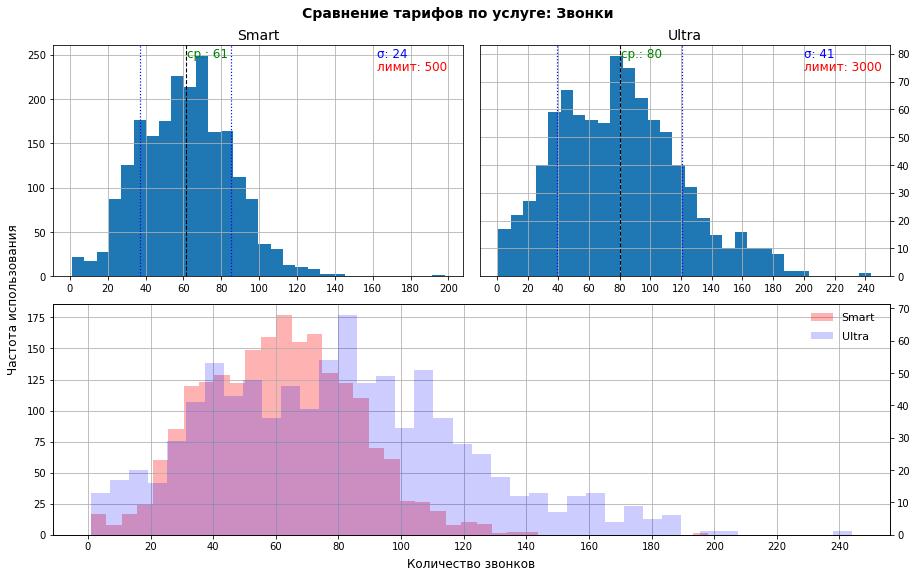

In [163]:
create_chart(df_outliers_clear('call_count',0.4),'call_count','Звонки','звонков',30,40,40,'minutes_included',20)

При сравнении тарифов, можно выделить следующее:
1. среднее потребление по тарифу `Smart` составляет 61 минут, против 80 минут по тарифу `Ultra`
2. стандартное отклонение по тарифу `Ultra` больше, 41 против 24 минут
3. все абоненты двух тарифов не использует полностью лимит минут
4. на сравнительном графике распределения минут по двум тарифам, что большие всплески на `Smart` наблюдается примерно на 50-70 минутах, а на `Ultra` на 80 минутах.

#### Сообщения

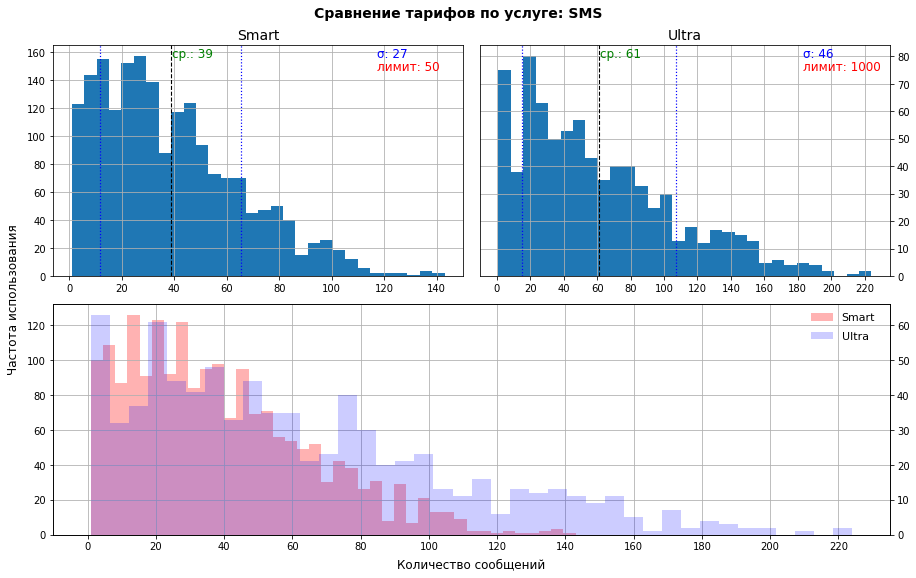

In [164]:
create_chart(df_billing,'message_count','SMS','сообщений', 30, 40, 40,'messages_included',20)

При сравнении тарифов, можно выделить следующее:
1. среднее потребление по тарифу `Smart` составляет 39 сообщений, против 61 по тарифу Ultra
2. стандартное отклонение по тарифу `Ultra` больше, 46 сообщений против 27
3. абоненты `Ultra` не используют предоставленный лимит полностью, при этом по `Smart` абоненты в основном укладываются в лимит 50 соообщений, но при этом многие абоненты выходят из лимита и отправляют СМС за отдельную плату
4. на сравнительном графике распределения смс по двум тарифам наблюдается всплески на `Ultra` в начале левой части графика, что говорит нам о не особой заинтересованности этих абонентов в использовании смс-сообщений. 

#### Интернет

График построен по очищенным на 5.8% данным


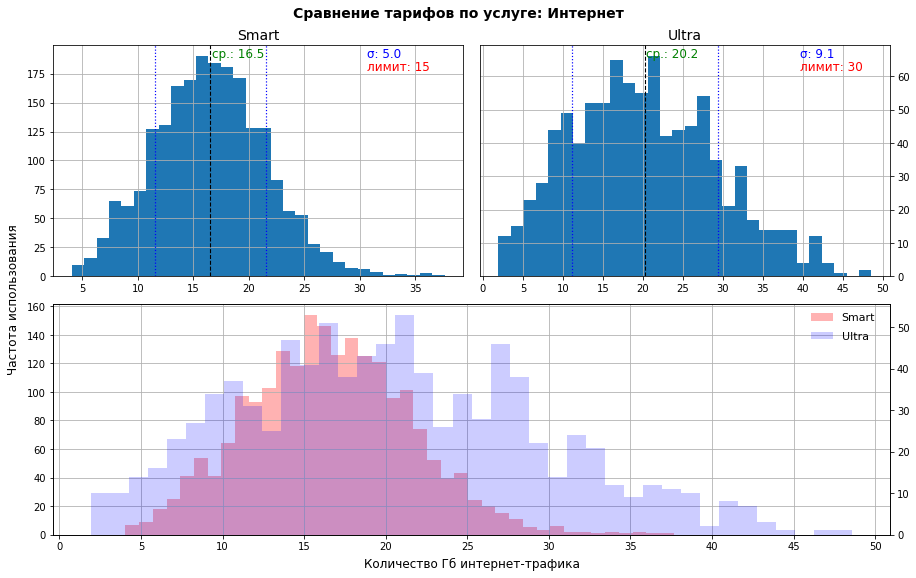

In [165]:
#создадим столбец в Гб
df_billing['gb_used'] = df_billing['mb_used']/1024
#график
create_chart(df_outliers_clear('gb_used',0.4),'gb_used','Интернет','Гб интернет-трафика', 30, 40, 40,'mb_per_month_included',5)

При сравнении тарифов в части интернета, можно выделить следующее:
1. среднее потребление по тарифу `Smart` составляет 16.5Гб, против 20.2Гб по тарифу Ultra
2. стандартное отклонение по тарифу `Ultra` больше, 9.1Гб против 5Гб
3. большая часть абонентов по тарифу `Smart` использует интернет сверх лимита в 15Гб, при этом на тарифе `Ultra` большая часть абонентов укладывается в лимит 30Гб.
4. на сравнительном графике распределения трафика по двум тарифам, что по тарифу `Smart` наблюдается более выраженное распределение в промежутке с 11 по 22 Гб, о чем мы не можем сказать об абонентах `Ultra`, где выражены всплески в районе 10 Гб, с 15 по 22 и с 25 по 28 Гб.

### Вывод
Как мы видим, поведение абонентов разных тарифов имеют различия, что вполне логично.
<br>Но мы также наблюдаем, что потребление в некоторых направлениях не столь разительно отличается, например в количестве минут, в `Smart` максимальное потребление составляет около 140 минут, а у `Ultra` 200 минут, при этом лимит у первой 500 минут, а второго 3000 минут.
<br>Тогда вопрос, стоит ли закладывать такие лимиты, если фактически абоненты их не используют и возможно это снизит цену тарифа? Но в этом мы также не можем быть уверены т.к. владеем только выборкой, а не генеральной совокупностью.
<br><br>В части статистических показателей, то как и ожидалось, средние показатели имели по `Ultra` имели более высокие показатели, но еще стоит обратить внимание на показатель стандартного отклонения, по `Ultra` он заметно выше чем на `Smart`. Можем предположить, что количество таких абонентов просто меньше, или потребности у данных абонентов в рамках одной группы отличаются. Например, предположим, что кто-то может брать себе такой тариф, потому что он может себе это позволить, но не использовать его практически, но есть и те, кто подключает его себе из-за действительной необходимости.

## Проверка гипотез и пояснения

Для удобства проверки гипотез создадим функцию, которая будет выдавать результат по заранее представленным аналитикам.
Используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам `scipy.stats.ttest_ind (array1, array2,equal_var)`

In [166]:
def hyp_test(col_name,col_v):
    #сделаем условие, где первая выручка равна переданному значение, а другая наоборот, что будет соответствовать логике наших гипотез
    revenue_1 = df_billing[df_billing[col_name]==col_v]['revenue']
    revenue_2 = df_billing[df_billing[col_name]!=col_v]['revenue']
    # критический уровень статистической значимости
    alpha = .05
    # результаты расчета
    results = st.ttest_ind(revenue_1, revenue_2)
    #отразим p-значение
    print('p-значение: ', results.pvalue)
    #проверка
    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")  

### Гипотеза 1
Проверим, различается ли средняя выручка пользователей тарифов «Ultra» и «Smart», для этого сформируем нулевую и альтернативную гипотезы:
* **Н0** - средняя выручка абонентов "Smart" и "Ultra" равны
* **Н1** - средняя выручка абонентов "Smart" и "Ultra" различается

In [167]:
hyp_test('tariff','smart')

p-значение:  1.4229814360764067e-160
Отвергаем нулевую гипотезу


По результатам проведенной проверки гипотезы, мы можем действительно предположить, что выручка по данным тарифам различается и один из них приносит оператору больше прибыли.

In [168]:
#посмотрим, сколько за год составила выручка по каждому из тарифу
print('Выручка по тарифу СМАРТ: {0:.1f} млн.руб.'.format(df_billing[df_billing['tariff']=='smart']['revenue'].sum()/1000000))
print('Выручка по тарифу УЛЬТРА: {0:.1f} млн.руб.'.format(df_billing[df_billing['tariff']=='ultra']['revenue'].sum()/1000000))
print()
print('Средняя выручка по тарифу СМАРТ: {0:.1f} тыс.руб.'.format(df_billing[df_billing['tariff']=='smart']['revenue'].mean()/1000))
print('Средняя выручка по тарифу УЛЬТРА: {0:.1f} тыс.руб.'.format(df_billing[df_billing['tariff']=='ultra']['revenue'].mean()/1000))

Выручка по тарифу СМАРТ: 2.9 млн.руб.
Выручка по тарифу УЛЬТРА: 2.0 млн.руб.

Средняя выручка по тарифу СМАРТ: 1.3 тыс.руб.
Средняя выручка по тарифу УЛЬТРА: 2.1 тыс.руб.


### Гипотеза 2
Проверим, различается ли средняя выручка пользователей из Москвы от других регионов, для этого сформируем нулевую и альтернативную гипотезы:
* **Н0** - средняя выручка абонентов Москвы и других регионов равны
* **Н1** - средняя выручка абонентов Москвы и других регионов отличаются

In [169]:
#так как в таблице биллинга у нас отсутсвует город, добавим его в таблицу для проверки гипотезы
#создадим словарь с пользователем и городом
dic_users_city = df_users.set_index('user_id')['city'].to_dict()
#добавляем столбец
df_billing['city'] = df_billing.apply(lambda x: dic_users_city.get(x['user_id']),axis=1)
#проверяем гипотезу

In [170]:
hyp_test('city','Москва')

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Таким образом, мы не можем подтвердить, что выручка от московских абонентов существенно отличается от выручки других регионов.

## Общий вывод

Мы проанализировать поведение клиентов и готовы сделать выводы по выбору наилучшего тарифа, согласно задаче нашего проекта.
<br>Для этого мы выполнили ряд процедур:
1. Ознакомились с общей информацией по представленным от Мегалайн данным и определили последующий порядок работы
2. Сформировали единую таблицу с данными по расходу трафика по каждому абоненту
3. Изменили типы данных в таблицах, что позволило сэкономить занимаемую таблицами память и повысить скорость работы
4. Расчитали выручку согласно условиям тарифа с помощью функции
5. Создали функцию для автоматизированного построения графиков

По итогам процедур были сделаны следующие выводы:
1. Звонки не самая популярная услуга по каждому из тарифов, ни по одному из них абоненты не превышают лимит
2. Абоненты тарифа Смарт чаще расходуют пакет СМС, при этом абоненты Ультра используют их в среднем в 2 раза чаще, но лимит не превышают
3. Интернет-трафик абоненты Смарта в среднем выходят за пределы пакета и платят дополнительно за Гб, а Ультра в среднем укладываются пакет. 

При проверке гипотез, мы выявили, что регион абонента не оказывает существенного влияния на выручку.
<br>Но при сравнении выручки по Ультре и Смарту мы выяснили, что они не равны и отвергли нулевую гипотезу. Хоть и средняя выручка по тарифу СМАРТ ниже почти в 2 раза, но в годовом выражении суммарная выручка по нему выше, что говорит о выгодности использования данного тарифа в дальнейшем.